# **Groundwater Quality Analysis 2021**

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from wordcloud import WordCloud

# preprocessing 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# model
from sklearn.tree import DecisionTreeClassifier


# model evalution
from sklearn.metrics import accuracy_score, f1_score

plt.style.use("dark_background")

# types
from typing import Literal

DataFrame = pd.DataFrame
Series = pd.Series

In [62]:
df = pd.read_excel("../data/GroundWater.xlsx")

### **Initial Dataset Exploration**

#### **General Analysis of the Dataset**

In [63]:
df.sample(5)

,Well ID,S.No,STATE,DISTRICT,BLOCK,LOCATION,LATITUDE,LONGITUDE,Year,pH,...,PO4,TH,Ca,Mg,Na,K,F,SiO2,TDS,U(ppb)
6182,NaN,6183,Chhattisgarh,Raipur,Arang,Kanki,21.400000,81.990000,2021,7.4,...,0.0,550.0,172.00,29.00,43.00,2.00,0.2,22,NaN,0.0
8395,NaN,8396,Uttar Pradesh,Lakhimpur Kheri,Gola,Block Development Office (BDO,28.069600,80.482800,2021,7.90,...,0,180.0,40.00,19.00,6.00,3.30,0.32,25,NaN,NaN
7609,NaN,7610,TAMIL NADU,Salem,AYOTHIYAPATTINAM,Ayodhayapattinam,11.669700,78.238900,2021,7.30,...,NaN,940.0,64.00,190.00,175.00,2.00,0.66,NaN,NaN,7.57
7803,NaN,7804,TAMIL NADU,Madurai,KALLUPATTI,T.Kallupatti,9.720800,77.855600,2021,7.69,...,NaN,390.0,44.00,68.00,234.00,0.31,1.6,NaN,NaN,1.66
2459,W255300090030001,2460,Meghalaya,West Garo Hills,Selsella,Phulbari,25.889722,90.036389,2021,6.58,...,NaN,145.0,22.02,21.83,26.52,3.73,0.41,NaN,95.17,NaN


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9059 entries, 0 to 9058
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Well ID    5789 non-null   object 
 1   S.No       9059 non-null   int64  
 2   STATE      9059 non-null   object 
 3   DISTRICT   9059 non-null   object 
 4   BLOCK      8865 non-null   object 
 5   LOCATION   9058 non-null   object 
 6   LATITUDE   9036 non-null   float64
 7   LONGITUDE  9039 non-null   float64
 8   Year       9059 non-null   int64  
 9   pH         9059 non-null   object 
 10  EC         9059 non-null   float64
 11  CO3        9059 non-null   object 
 12  HCO3       9059 non-null   float64
 13  Cl         9059 non-null   float64
 14  SO4        9057 non-null   object 
 15  NO3        9059 non-null   object 
 16  PO4        5715 non-null   object 
 17  TH         9059 non-null   float64
 18  Ca         9058 non-null   float64
 19  Mg         9059 non-null   float64
 20  Na      

In [65]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
S.No,9059.0,4530.000000,2615.252378,1.0000,2265.500000,4530.0000,6794.50000,9059.00
LATITUDE,9036.0,82.956861,3836.477584,8.0833,21.099827,23.5296,26.79365,292505.00
LONGITUDE,9039.0,8509.949469,775790.829004,21.0000,76.114600,78.8982,83.19000,73744005.00
Year,9059.0,2021.000000,0.000000,2021.0000,2021.000000,2021.0000,2021.00000,2021.00
EC,9059.0,1140.598720,1561.435325,0.0000,438.000000,723.0000,1242.50000,37230.00
HCO3,9059.0,273.613763,173.313292,0.0000,159.000000,250.0000,356.00000,1915.00
Cl,9059.0,166.245229,394.889199,0.0000,25.000000,57.0000,149.00000,9075.00
TH,9059.0,301.899638,315.453527,0.0000,150.000000,230.0000,350.00000,5454.36
Ca,9058.0,57.129489,54.473873,0.0000,24.540000,44.0000,72.00000,1014.00
Mg,9059.0,38.545363,53.306452,-23.0000,13.450000,26.0000,44.00000,1136.00


In [66]:
df.describe(include="O").T

,count,unique,top,freq
Well ID,5789,5455,W114909093023001,8
STATE,9059,26,Madhya Pradesh,1153
DISTRICT,9059,483,Raigarh,124
BLOCK,8865,3267,Dharmajaigarh,35
LOCATION,9058,8097,Block office,155
pH,9059.0,375.0,7.7,192.0
CO3,9059,118,0,6618
SO4,9057,1855,0,514
NO3,9059,1349,0,894
PO4,5715,174,0,3229


In [67]:
df.shape

(9059, 26)

#### **Data Type Conversion**

In [68]:
df.dtypes

Well ID       object
S.No           int64
STATE         object
DISTRICT      object
BLOCK         object
LOCATION      object
LATITUDE     float64
LONGITUDE    float64
Year           int64
pH            object
EC           float64
CO3           object
HCO3         float64
Cl           float64
SO4           object
NO3           object
PO4           object
TH           float64
Ca           float64
Mg           float64
Na           float64
K            float64
F             object
SiO2          object
TDS          float64
U(ppb)        object
dtype: object

In [69]:
for cols in df.select_dtypes(include="O").columns:
    print(cols)
    print(df[cols].unique())
    print("--"*50)

Well ID
['W113126092431802' 'W113616092411001' 'W113640092443301' ...
 'W254116088130201' 'W253750088210101' nan]
----------------------------------------------------------------------------------------------------
STATE
['A&N Islands' 'Andhra Pradesh' 'Arunachal Pradesh' 'Assam' 'Bihar'
 'Chandigarh' 'Chhattisgarh' 'Delhi' 'Gujarat' 'Haryana'
 'Himanchal Pradesh' 'Jammu & Kashmir' 'Jharkhand' 'Kerala' 'Maharashtra'
 'Meghalaya' 'Madhya Pradesh' 'Odisha' 'Punjab' 'RAJASTHAN' 'TAMIL NADU'
 'Telangana' 'Tripura' 'Uttar Pradesh' 'Uttrakhand' 'West Bengal']
----------------------------------------------------------------------------------------------------
DISTRICT
['South Andaman' 'N&M Andaman' 'Long Island' 'Havelock' 'Neil Island'
 'Ross Island' 'Havelock Island' 'Visakhapatnam' 'PAPUMPARE' 'Changlang'
 'Lower Dibang valley' 'Tirap' 'Lohit' 'East Kaarbi-Anglong' 'Nagaon'
 'Kamrup Metro' 'Karbi Anglong' 'Kamrup' 'Morigaon' 'Goalpara' 'Tinsukia'
 'Nalbari' 'DHEMAJI' 'Cachar' 'LAKHIMPUR' '

In [70]:
cols = ["pH", "CO3", "SO4", "NO3", "PO4", "F", "SiO2", "U(ppb)"]
for each in cols:
    df[each] = pd.to_numeric(df[each], errors="coerce")

In [71]:
df.dtypes

Well ID       object
S.No           int64
STATE         object
DISTRICT      object
BLOCK         object
LOCATION      object
LATITUDE     float64
LONGITUDE    float64
Year           int64
pH           float64
EC           float64
CO3          float64
HCO3         float64
Cl           float64
SO4          float64
NO3          float64
PO4          float64
TH           float64
Ca           float64
Mg           float64
Na           float64
K            float64
F            float64
SiO2         float64
TDS          float64
U(ppb)       float64
dtype: object

#### **Remove Unnecessary Columns & Duplicated Rows**

In [72]:
columns_non_relevent = ['Well ID', 'S.No', 'Year', 'BLOCK', 'LOCATION']
df = df.drop(columns=columns_non_relevent)

In [73]:
# drop columns that have too many missing values

# drop columns that have null values > 50%
df = df.loc[:,df.isna().mean() * 100 < 50]

# drop rows that have null values > 50%
df = df.loc[df.isna().mean(axis=1) * 100 < 50]

In [74]:
# drop duplicate rows
df = df[~df.duplicated()]

In [75]:
numerical_cols = df.select_dtypes(include=np.number).columns
catagorical_cols = df.select_dtypes(include="O").columns

### **Data Cleaning and Preprocessing**

#### **Handle Missing Values**

In [76]:
nan_value_mean = df.isna().mean() * 100
nan_value_mean

STATE         0.000000
DISTRICT      0.000000
LATITUDE      0.253975
LONGITUDE     0.220848
pH            0.011042
EC            0.000000
CO3           1.049028
HCO3          0.000000
Cl            0.000000
SO4           0.033127
NO3           0.011042
PO4          38.703622
TH            0.000000
Ca            0.011042
Mg            0.000000
Na            0.000000
K             0.011042
F             0.541078
SiO2         47.780477
TDS          49.922703
dtype: float64

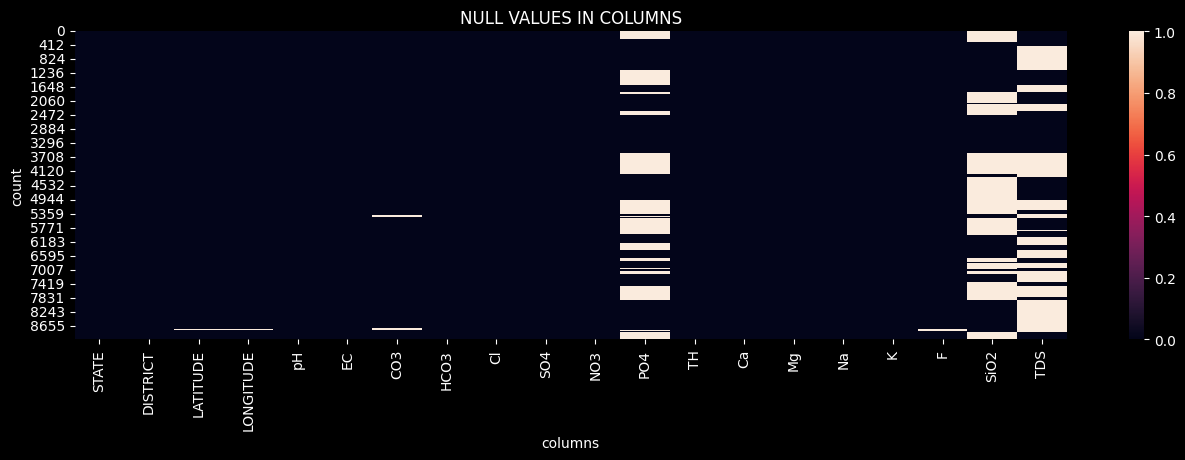

In [77]:
plt.figure(figsize=(16,4))

plt.title("NULL VALUES IN COLUMNS")
sns.heatmap(df.isna())

plt.xlabel("columns")
plt.ylabel("count")
plt.show()

In [78]:
def impute_nan_values(data: Series, strategy: Literal["mean", "median", "mode"]) -> Series:
    """
    impute data using provided strategy

    Args:
        data (Series) : data to impute
        strategy (Literal) ["mean", "median", "mode"] = option to perform imputation

    Returns:
        Series : imputed data
    """
    match (strategy):
        case "mean":
            data_mean = data.mean()
            return data.fillna(data_mean)

        case "median":
            data_median = data.median()
            return data.fillna(data_median)

        case "mode":
            data_mode = data.mode()[0]
            return data.fillna(data_mode)
            

In [79]:
less_nan_cols = nan_value_mean[nan_value_mean < 10].index[3:]    # ignore catagorical variables
higer_nan_cols = nan_value_mean[nan_value_mean > 10].index
cat_nan_cols = nan_value_mean[nan_value_mean < 10].index[:3]

In [80]:
cat_nan_cols        # catagorical columns

Index(['STATE', 'DISTRICT', 'LATITUDE'], dtype='object')

In [81]:
higer_nan_cols         # numerical columns that have higher nan values

Index(['PO4', 'SiO2', 'TDS'], dtype='object')

In [82]:
less_nan_cols          # numerical columns with less nan values

Index(['LONGITUDE', 'pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca',
       'Mg', 'Na', 'K', 'F'],
      dtype='object')

In [83]:
df_copy = deepcopy(df)

In [84]:
for each in less_nan_cols:
    df_copy[each] = impute_nan_values(df_copy[each], strategy="mean")

In [85]:
for each in higer_nan_cols:
    df_copy[each] = impute_nan_values(df_copy[each], strategy="median")

In [86]:
for each in cat_nan_cols:
    df_copy[each] = impute_nan_values(df_copy[each], strategy="mode")

In [87]:
df_copy.isna().sum()

STATE        0
DISTRICT     0
LATITUDE     0
LONGITUDE    0
pH           0
EC           0
CO3          0
HCO3         0
Cl           0
SO4          0
NO3          0
PO4          0
TH           0
Ca           0
Mg           0
Na           0
K            0
F            0
SiO2         0
TDS          0
dtype: int64

In [88]:
df = df_copy

#### **Outlier Detection and Treatment**

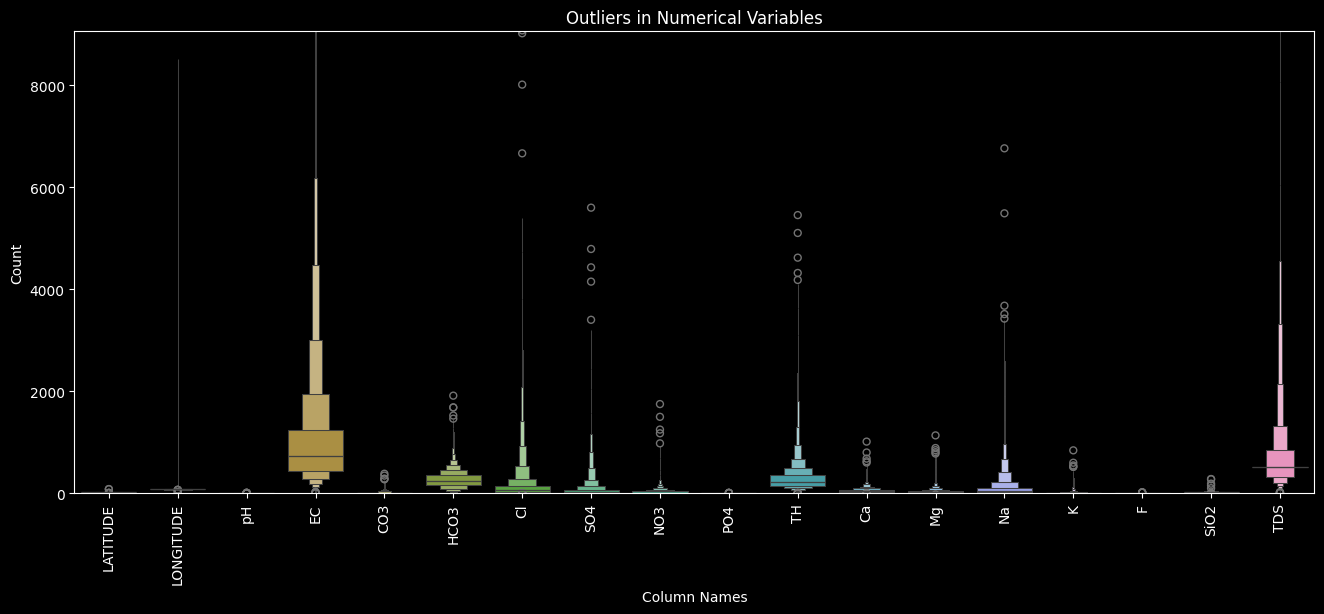

In [89]:
plt.figure(figsize=(16,6))
sns.boxenplot(df[numerical_cols])
plt.ylim(0,len(df))
plt.xticks(rotation=90)

plt.title("Outliers in Numerical Variables")

plt.ylabel("Count")
plt.xlabel("Column Names")
plt.show()

In [90]:
def iqr_range(data: Series) -> 'tuple(int, int)':
    """
    helper function for outlier treatment using IQR

    Args:
        data (Series) : <int> data values

    Returns:
        tuple(int, int) : (lower_limit, upper_limit)
    """
    
    Q1, Q3 = data.quantile([.15, .90])
    IQR = Q3 - Q1
    threshold = 3
    lower_limit = Q1- (IQR * threshold)
    upper_limit = Q3 + (IQR * threshold)
    return lower_limit, upper_limit

In [91]:
data = {}
copy_df = deepcopy(df)
for cols in numerical_cols:
    lower_limit, upper_limit = iqr_range(df[cols])
    outliers = copy_df[~copy_df[cols].between(lower_limit, upper_limit)]
    total_data = df.shape[0]
    percentage = (outliers.shape[0]/total_data) * 100
    data[cols] = {"total data" : total_data,
                  "outlier count" : outliers.shape[0], 
                  "outlier percentage" : f"{percentage: .1f}%"}

outlier_df = DataFrame(data)

In [92]:
outlier_df

,LATITUDE,LONGITUDE,pH,EC,CO3,HCO3,Cl,SO4,NO3,PO4,TH,Ca,Mg,Na,K,F,SiO2,TDS
total data,9056,9056,9056,9056,9056,9056,9056,9056,9056,9056,9056,9056,9056,9056,9056,9056,9056,9056
outlier count,6,27,18,84,103,3,146,195,62,265,64,32,78,108,171,54,17,182
outlier percentage,0.1%,0.3%,0.2%,0.9%,1.1%,0.0%,1.6%,2.2%,0.7%,2.9%,0.7%,0.4%,0.9%,1.2%,1.9%,0.6%,0.2%,2.0%


In [93]:
df_copy = deepcopy(df)

In [94]:
for each in numerical_cols:
    lower_limit, upper_limit = iqr_range(df_copy[each])
    df_copy = df_copy[df_copy[each].between(lower_limit, upper_limit)]

In [95]:
df = df_copy

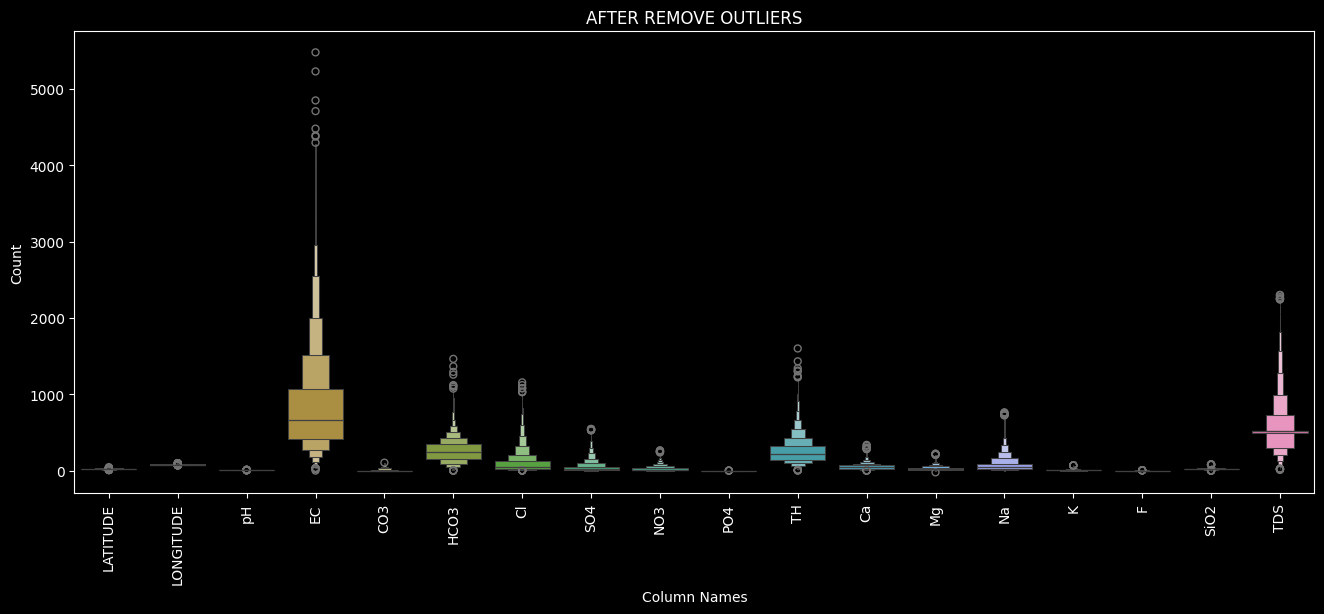

In [96]:
plt.figure(figsize=(16,6))
sns.boxenplot(df[numerical_cols])
plt.xticks(rotation=90)

plt.title("AFTER REMOVE OUTLIERS")

plt.ylabel("Count")
plt.xlabel("Column Names")
plt.show()

### **Exploratory Data Analysis (EDA)**

#### **Catagorical Variables Distribution**

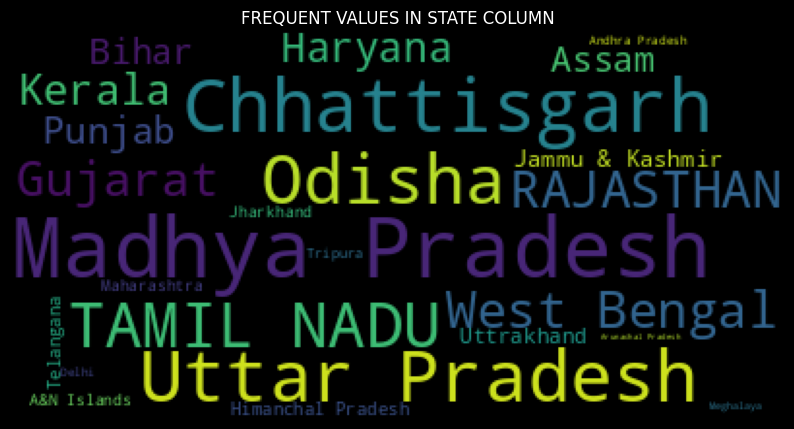

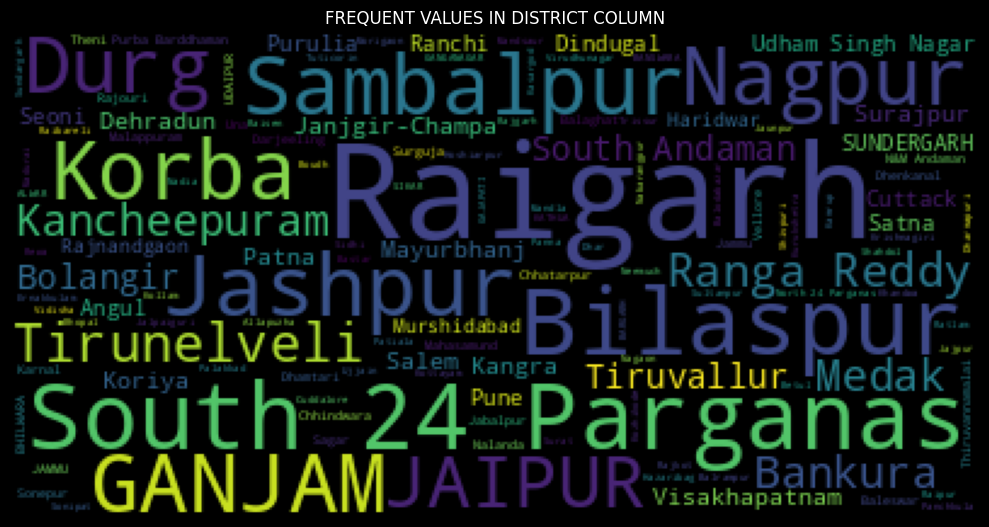

In [97]:
for each in catagorical_cols:
    fig, ax = plt.subplots(1,1, figsize=(10,8))
    plt.title(f"FREQUENT VALUES IN {each} COLUMN")
    word_cloud = WordCloud().generate_from_frequencies(df[each].value_counts())
    plt.axis("off")
    plt.imshow(word_cloud)

plt.tight_layout()
plt.show()

#### **Water Quality Distribution**

<Figure size 640x480 with 0 Axes>

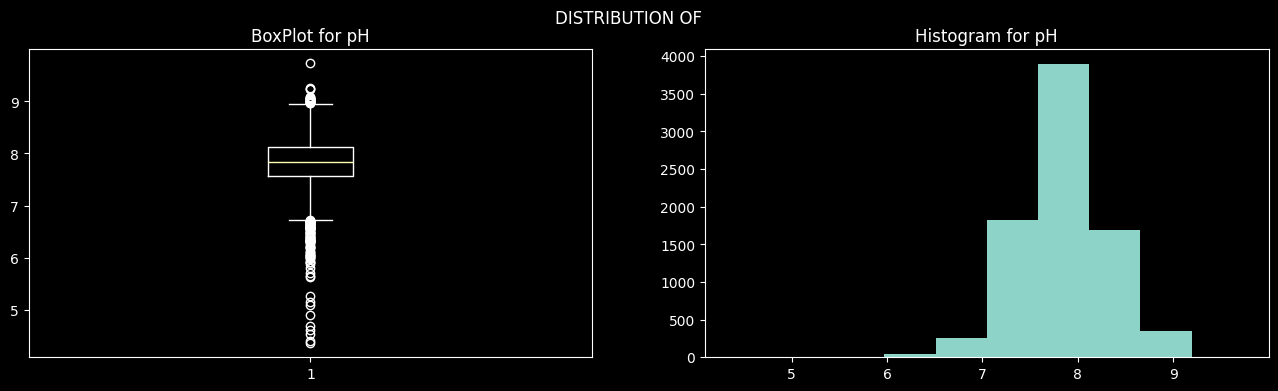

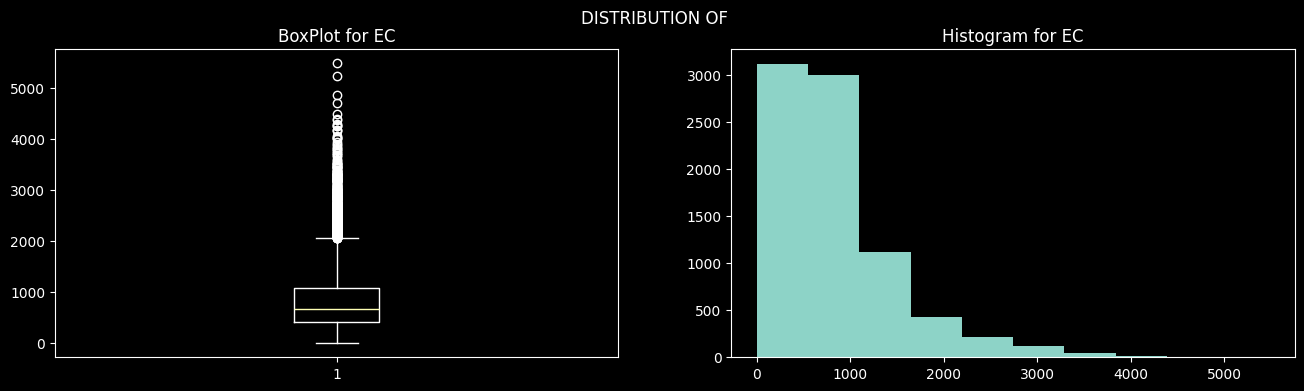

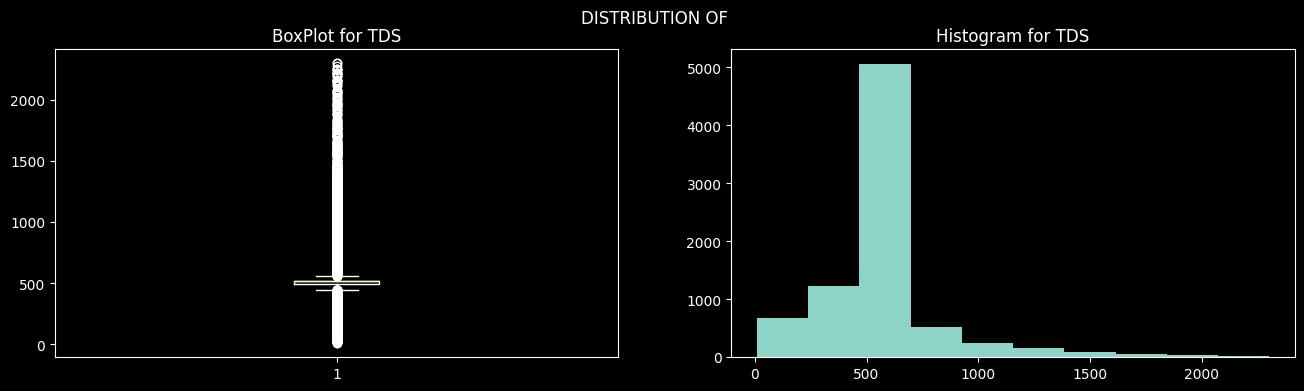

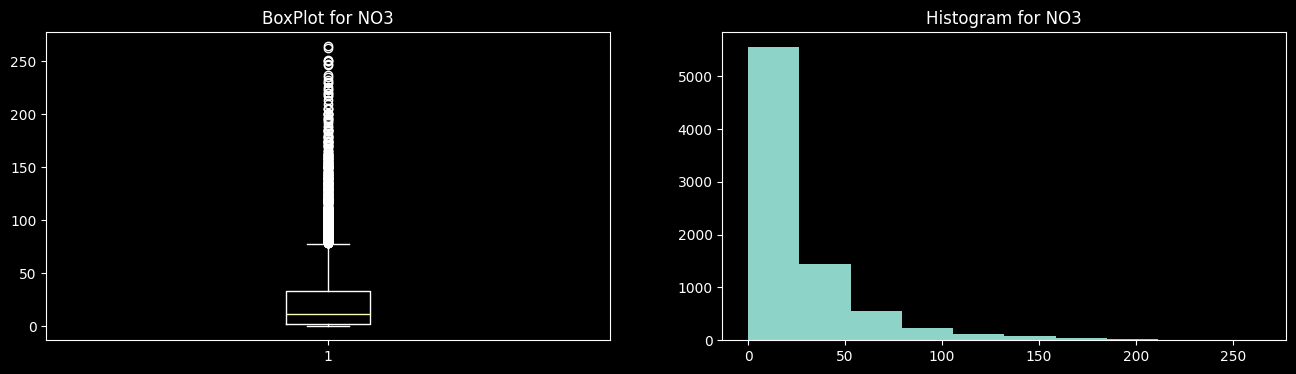

In [98]:
main_params = ["pH", "EC", "TDS", "NO3"]

for each in main_params:
    plt.suptitle("DISTRIBUTION OF")
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    
    ax[0].boxplot(df[each])
    ax[0].set_title(f"BoxPlot for {each}")

    ax[1].hist(df[each])
    ax[1].set_title(f"Histogram for {each}")

In [99]:
by_state = df.groupby('STATE')[main_params].mean().reset_index()
by_state.head(2)

,STATE,pH,EC,TDS,NO3
0,A&N Islands,7.617636,513.681818,302.609091,1.536364
1,Andhra Pradesh,7.273585,1131.509434,520.000000,36.716981


In [100]:
by_state_melted = by_state.melt(id_vars="STATE", var_name="params", value_name="values")
by_state_melted.head(2)

,STATE,params,values
0,A&N Islands,pH,7.617636
1,Andhra Pradesh,pH,7.273585


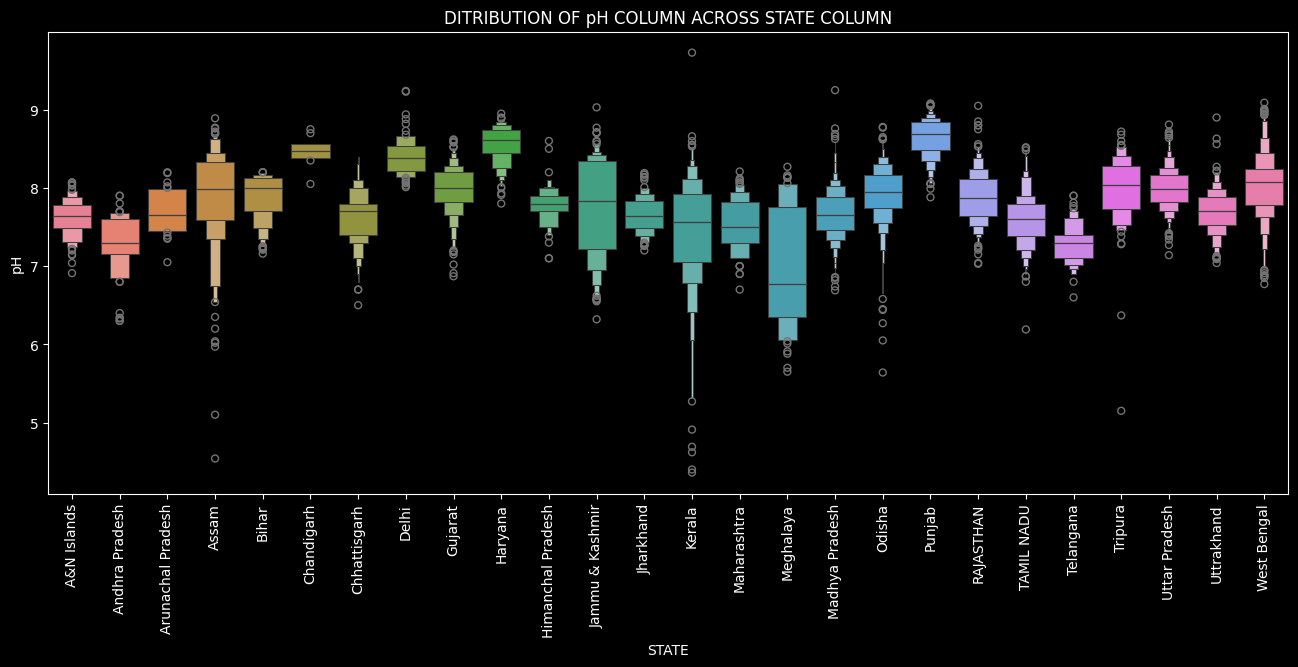

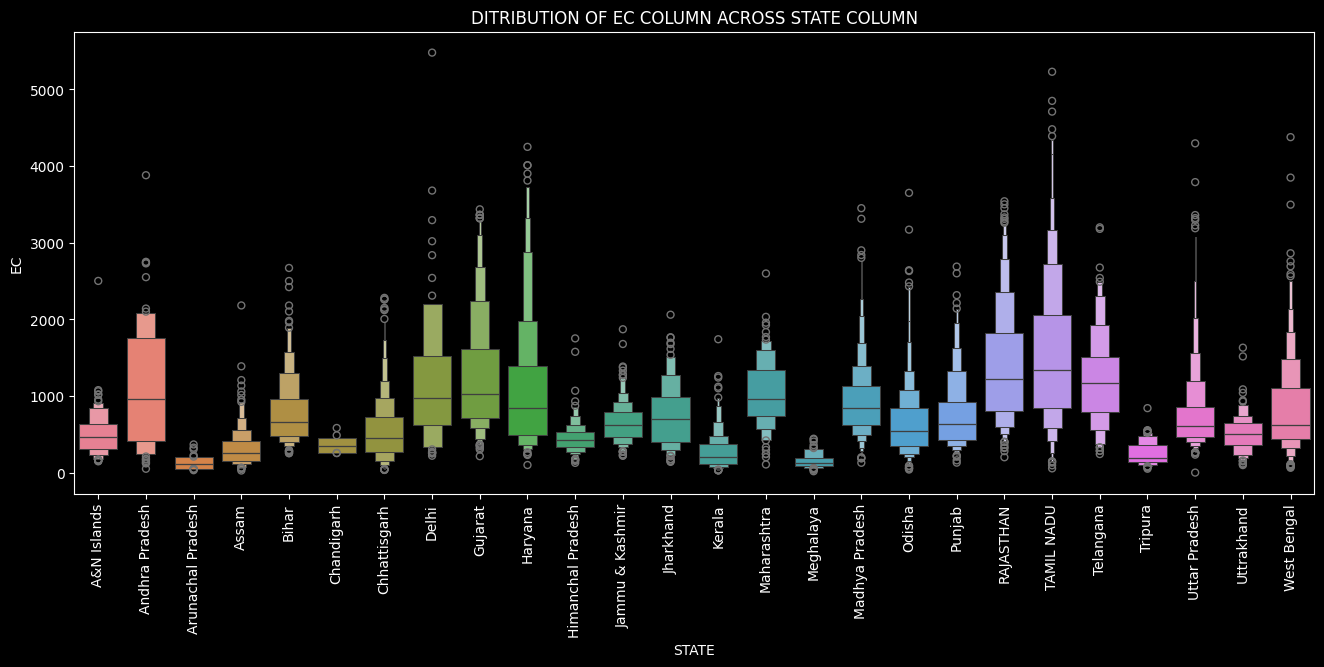

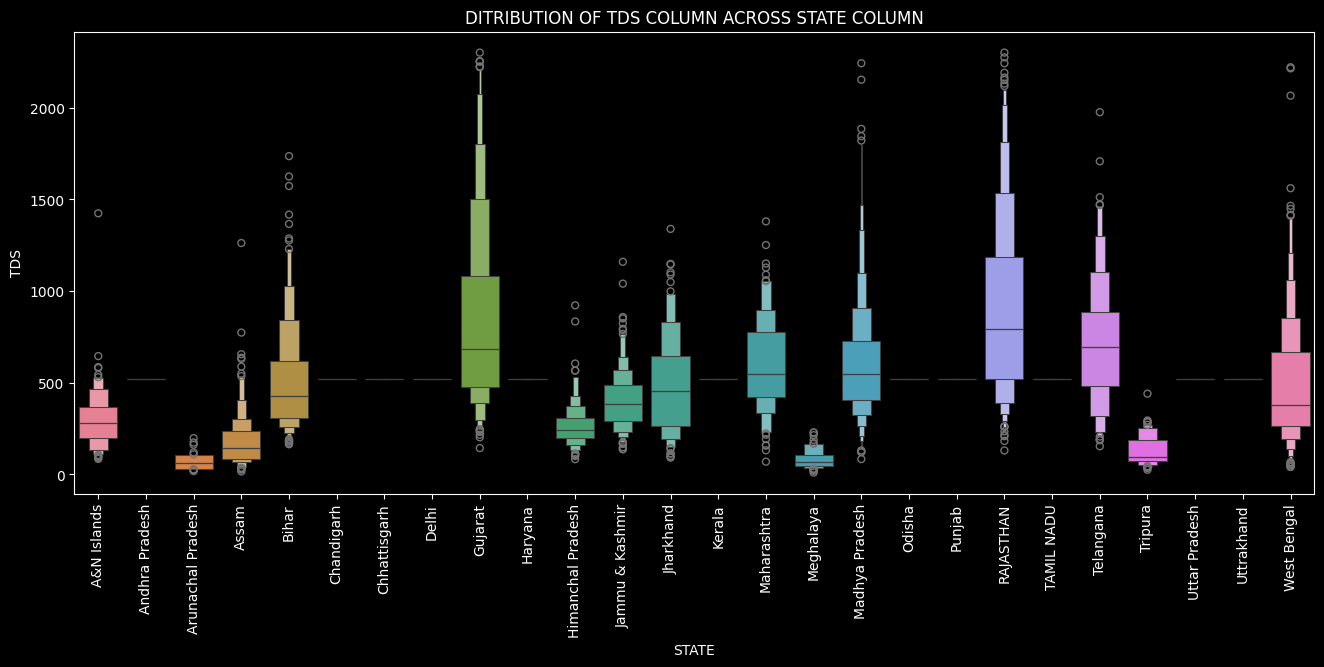

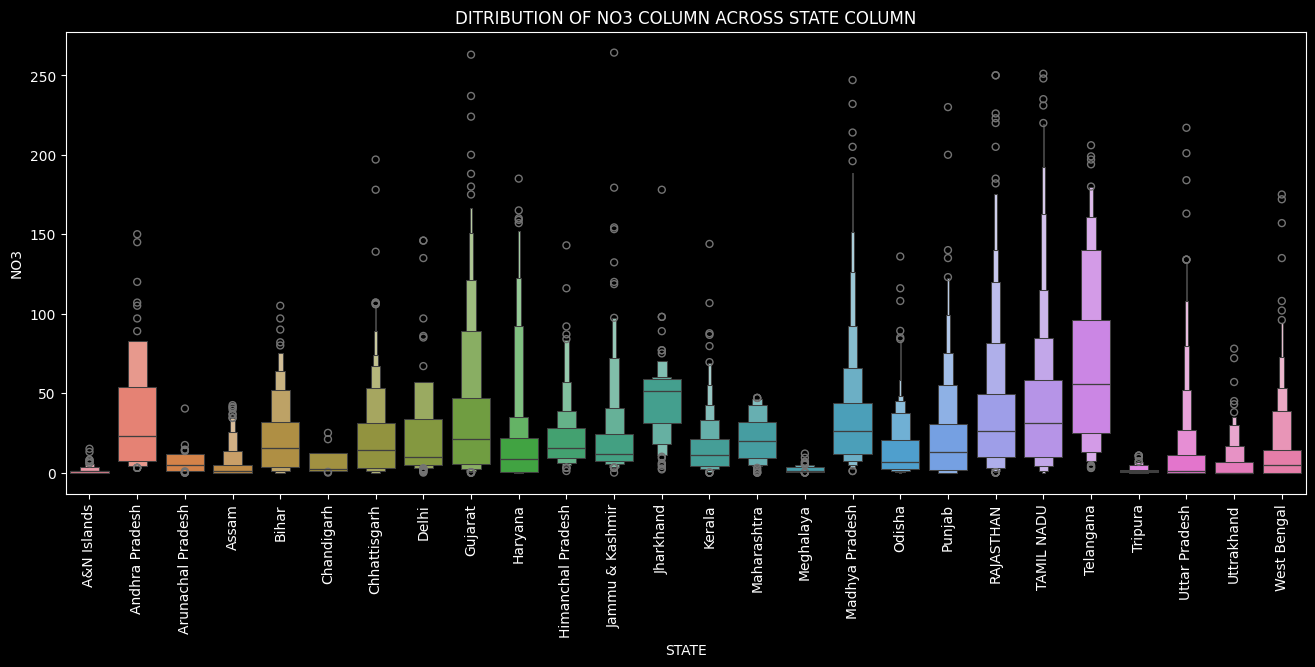

In [101]:
for each in main_params:
    fig, ax = plt.subplots(1,1, figsize=(16,6))
    sns.boxenplot(data=df, x="STATE", y=each, hue="STATE")
    plt.title(f"DITRIBUTION OF {each} COLUMN ACROSS STATE COLUMN")
    plt.xticks(rotation=90)
plt.show()
    

#### **Correlation Analysis**

In [102]:
corr_matrix = df[numerical_cols].corr()

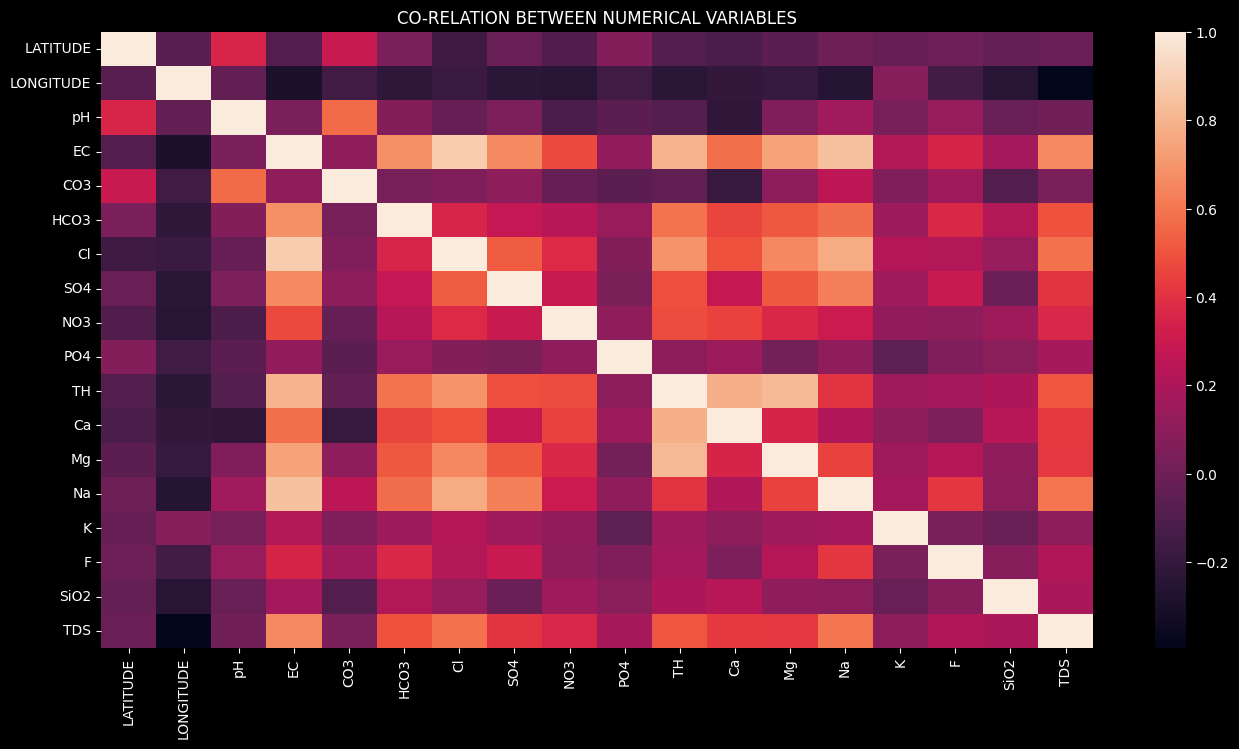

In [103]:
plt.figure(figsize=(16,8))
plt.title("CO-RELATION BETWEEN NUMERICAL VARIABLES")
sns.heatmap(corr_matrix)
plt.show()

<Figure size 1800x2600 with 0 Axes>

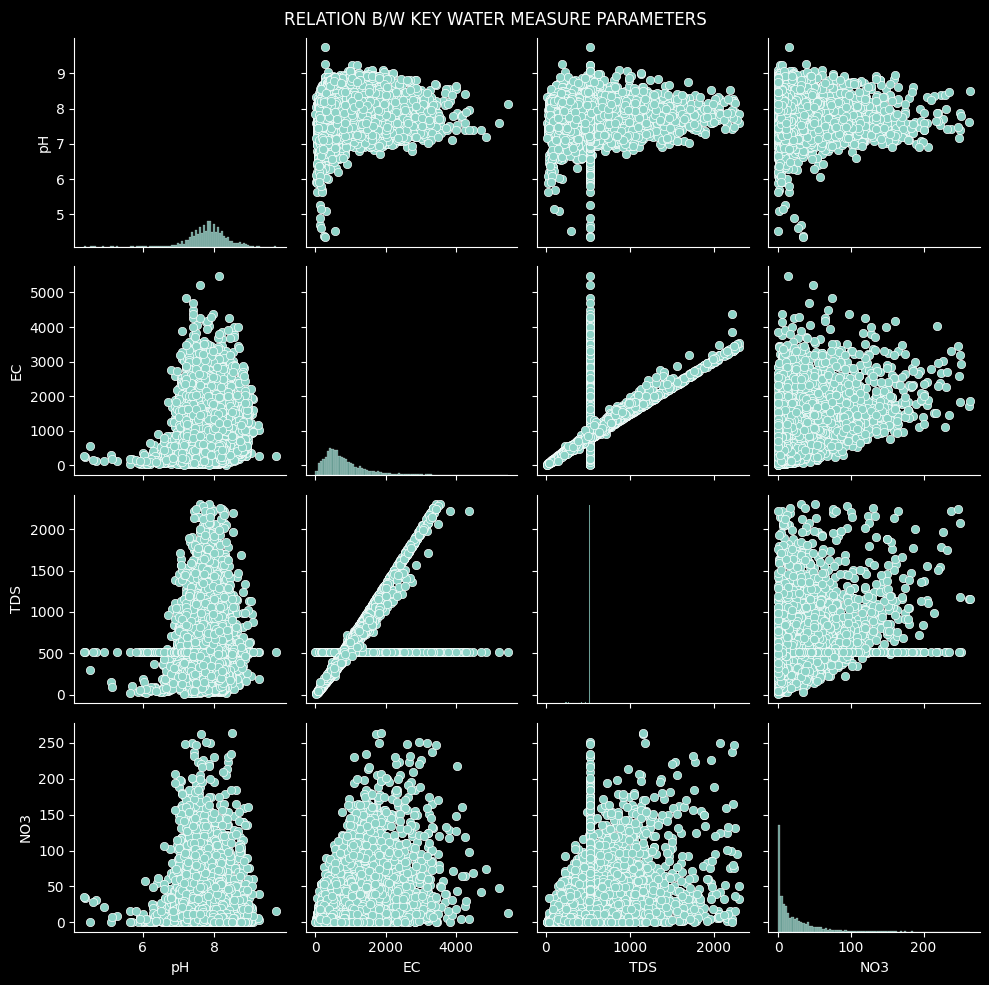

In [104]:
plt.figure(figsize=(18,26))
sns.pairplot(df[main_params])
plt.suptitle("RELATION B/W KEY WATER MEASURE PARAMETERS")
plt.tight_layout()
plt.show()

### **Feature Engineering**

#### **Create New Features**

##### **Hardness Level**
- Hardness (mg/L CaCO3) = (Ca concentration (mg/L) x 2.497) + (Mg concentration (mg/L) x 4.118)
- **Condition**
    - Soft: less than 60 mg/L CaCO3 
    - Moderately: 61 - 120 mg/L CaCO3 
    - Hard: greater than 120 mg/L CaCO3 

In [105]:
def hardness_level(ca: float, mg: float) -> str:
    hardness = (ca * 2.497) + (mg * 4.118)
    
    if hardness <= 60:
        return "Soft"
        
    elif hardness >= 61 and hardness <= 120:
        return "Moderately"
        
    else:
        return "Hard"

df['HARDNESS'] = df.apply(lambda row: hardness_level(ca=row["Ca"], mg=row['Mg']), axis=1)
df['HARDNESS'].value_counts()

HARDNESS
Hard          6596
Moderately     980
Soft           499
Name: count, dtype: int64

##### **Water Quality**
- **Parameters:**
    - pH: Measures how acidic or alkaline the water is.
    - EC: Measures the water's ability to conduct electrical current.
    - TDS: Total dissolved solids give an estimate of all inorganic and organic substances dissolved in water, including minerals, salts, and ions.
- **Condition**
    - Safe: *(ph between 6.5 & 8.5)* AND *(ec between 0 & 1000)* AND *(tds between 0 & 600)*
    - Moderately: *(ph between (6 & 6.6) OR (8.5 & 9.0))* OR *(ec between 1000 & 2000)* OR *(tds between 600 & 1500)*
    - Unsafe: *(ph below 6 || above 9.0)* OR *(ec above 2000)* OR *(tdc above 1500)*

In [106]:
def water_quality(ph: float, ec: float, tds: float) -> str:
    
    if (6.5 <= ph <= 8.5) and (0 < ec <= 1000) and (0 < tds <= 600):
        return "Safe"
        
    elif ((6 <= ph < 6.5) or (8.5 < ph <= 9.0)) or (1000 < ec <= 2000) or (600 < tds <= 1500):
        return "Moderately Safe"
        
    elif (ph < 6 or ph > 9) or (ec > 2000) or (tds > 1500):
        return "Unsafe"
    return "Unknown Quality"


df['QUALITY'] = df.apply(lambda row: water_quality(ph=row["pH"], ec=row["EC"], tds=row["TDS"]), axis=1)
df['QUALITY'].value_counts()

QUALITY
Safe               5194
Moderately Safe    2486
Unsafe              394
Unknown Quality       1
Name: count, dtype: int64

In [108]:
df.to_csv("../data/preprocessed.csv", index=False) # need to save dataset for further features

#### **Encode Categorical Variables**

In [109]:
categorical_cols = df.select_dtypes(include="O").columns

In [110]:
for each in categorical_cols:
    nunique = df[each].nunique()
    if nunique <= 10:
        cardinality_level = "Low"
    elif 10 < nunique < 100:
        cardinality_level = "Medium"
    else:
        cardinality_level = "High"
        
    print(f"{each}: {nunique = } : {cardinality_level} Cardinality Feature")

STATE: nunique = 26 : Medium Cardinality Feature
DISTRICT: nunique = 476 : High Cardinality Feature
HARDNESS: nunique = 3 : Low Cardinality Feature
QUALITY: nunique = 4 : Low Cardinality Feature


- **For High/Medium Cardinality Feature we gonna use "Frequency Encoder"**
- **For Low Cardinality "Label Encoder"**

##### **Low Cardinality Encoding**

In [111]:
label_encoding_cols = ["HARDNESS", "QUALITY"]

category_mappings = {}
for cols in label_encoding_cols:
    label_encoder = LabelEncoder()
    df[cols] = label_encoder.fit_transform(df[cols])
    category_mappings[cols] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("\nCategory to label mappings:")
for col, mapping in category_mappings.items():
    print(f"{col}: {mapping}")
    print("--" * 50)


Category to label mappings:
HARDNESS: {'Hard': np.int64(0), 'Moderately': np.int64(1), 'Soft': np.int64(2)}
----------------------------------------------------------------------------------------------------
QUALITY: {'Moderately Safe': np.int64(0), 'Safe': np.int64(1), 'Unknown Quality': np.int64(2), 'Unsafe': np.int64(3)}
----------------------------------------------------------------------------------------------------


##### **High/Medium Cardinality Encoding**

In [112]:
frequency_encoding_cols = ["STATE", "DISTRICT"]

category_mappings = {}
for cols in frequency_encoding_cols:
    frequency = df[cols].value_counts()
    df[cols] = df[cols].map(frequency)
    
    category_mappings[cols] = frequency

print("\nCategory to label mappings:")
for col, mapping in category_mappings.items():
    print(f"{col}: {mapping}")
    print("--" * 50)


Category to label mappings:
STATE: STATE
Madhya Pradesh       1112
Chhattisgarh          844
Uttar Pradesh         811
Odisha                702
TAMIL NADU            569
West Bengal           490
RAJASTHAN             483
Gujarat               438
Kerala                327
Haryana               313
Punjab                262
Assam                 228
Bihar                 228
Jammu & Kashmir       226
Uttrakhand            185
Himanchal Pradesh     138
Telangana             132
A&N Islands           110
Jharkhand             106
Maharashtra           103
Tripura                90
Delhi                  55
Andhra Pradesh         53
Meghalaya              44
Arunachal Pradesh      18
Chandigarh              8
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
DISTRICT: DISTRICT
Raigarh                119
South 24 Parganas       84
Bilaspur                83
Jashpur                 68
Sambalpur               66
 

#### **Split into Feature & Target (X,Y)**

In [113]:
X = df.drop(["QUALITY"], axis=1)
Y = df["QUALITY"]

In [114]:
X.sample()

,STATE,DISTRICT,LATITUDE,LONGITUDE,pH,EC,CO3,HCO3,Cl,SO4,...,PO4,TH,Ca,Mg,Na,K,F,SiO2,TDS,HARDNESS
8926,490,29,26.57806,88.575,8.22,151.0,0.0,43.0,14.0,0.0,...,0.0,40.0,8.0,5.0,15.0,6.0,1.14,24.0,100.0,2


In [115]:
Y.sample()

3433    1
Name: QUALITY, dtype: int64

#### **Standardize Data**

In [116]:
standard_scalar = StandardScaler()
scalar = standard_scalar.fit_transform(X)

X_scaled = DataFrame(scalar, columns=X.columns)
X_scaled.head()

,STATE,DISTRICT,LATITUDE,LONGITUDE,pH,EC,CO3,HCO3,Cl,SO4,...,PO4,TH,Ca,Mg,Na,K,F,SiO2,TDS,HARDNESS
0,-1.452495,1.147702,-2.012162,2.395142,-0.209175,-0.764791,-0.341472,-0.488890,-0.565856,-0.651349,...,-0.301941,-0.467483,-0.455430,-0.322001,-0.707904,-0.697724,0.736464,-0.052759,-1.218736,-0.440987
1,-1.452495,1.147702,-2.002056,2.392079,-0.664963,-0.285130,-0.341472,0.023587,-0.133965,-0.592175,...,-0.301941,-0.025850,0.012633,-0.053353,-0.279174,-0.593288,-0.430802,-0.052759,-0.590521,-0.440987
2,-1.452495,1.147702,-1.998834,2.392133,-0.730076,-0.886634,-0.341472,-0.923523,-0.490086,-0.651349,...,-0.301941,-0.761905,-1.235536,-0.091731,-0.707904,-0.593288,-0.055609,-0.052759,-1.416175,-0.440987
3,-1.452495,1.147702,-1.979205,2.387941,-0.513034,-0.823399,-0.341472,-0.644580,-0.459778,-0.636556,...,-0.301941,-0.703021,-0.663458,-0.513892,-0.655620,-0.488852,-0.243206,-0.052759,-1.247454,-0.440987
4,-1.452495,1.147702,-1.991314,2.378161,-0.035542,2.554277,-0.341472,1.645351,3.487861,0.162303,...,-0.301941,1.240166,0.116647,1.865562,2.701025,1.182119,0.965749,-0.052759,3.153643,-0.440987


#### **Train Test Split**

In [117]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled,Y, test_size=.2, random_state=435)

In [118]:
x_train.shape, y_train.shape

((6460, 21), (6460,))

In [119]:
x_test.shape, y_test.shape

((1615, 21), (1615,))

### **Predictive Modeling**

In [120]:
# TODO